In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import sys
from gensim.models import ldamodel, CoherenceModel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import re
import string
import spacy
import pickle

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('JEOPARDY_CSV.csv')
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [3]:
df.columns = ['show_id', 'date', 'round', 'category', 'value', 'question', 'answer']

In [4]:
df['value'].replace({'None': '$0'}, inplace=True)

In [5]:
df['value'] = df['value'].apply(lambda x: int(x[1:].replace(',',''))) #remove $ remove comma and convert to int

In [6]:
df['year'] = df['date'].apply(lambda x: int(x[:4]))

In [7]:
df.head()

,show_id,date,round,category,value,question,answer,year
0,4680,2004-12-31,Jeopardy!,HISTORY,200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200,The city of Yuma in this state has a record av...,Arizona,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004


### Split df by value  
Here we split the data into groups based on question value. Values are binned such that questions within $200 of each other are in the same group.

In [19]:
df.value.unique()

array([  200,   400,   600,   800,  2000,  1000,  1200,  1600,  3200,
           0,  5000,   100,   300,   500,  1500,  4800,  1800,  1100,
        2200,  3400,  3000,  4000,  6800,  1900,  3100,   700,  1400,
        2800,  8000,  6000,  2400, 12000,  3800,  2500,  6200, 10000,
        7000,  1492,  7400,  1300,  7200,  2600,  3300,  5400,  4500,
        2100,   900,  3600,  2127,   367,  4400,  3500,  2900,  3900,
        4100,  4600, 10800,  2300,  5600,  1111,  8200,  5800,   750,
        7500,  1700,  9000,  6100,  1020,  4700,  2021,  5200,  3389,
        4200,     5,  2001,  1263,  4637,  3201,  6600,  3700,  2990,
        5500, 14000,  2700,  6400,   350,  8600,  6300,   250,  3989,
        8917,  9500,  1246,  6435,  8800,  2222,  2746, 10400,  7600,
        6700,  5100, 13200,  4300,  1407, 12400,  5401,  7800,  1183,
        1203, 13000, 11600, 14200,  1809,  8400,  8700, 11000,  5201,
        1801,  3499,  5700,   601,  4008,    50,  2344,  2811, 18000,
        1777,  3599,

In [30]:
df = df.sort_values('value')
bins =  np.arange(0, 18000, 200)
ind = np.digitize(df['value'], bins)

In [31]:
dfs= [x for _, x in df.groupby(ind)]

In [32]:
len(dfs)

64

# Perform LDA on each group separately

In [35]:
# adapted from https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Stemming
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    all_stopwords = nlp.Defaults.stop_words
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags and token not in all_stopwords])
    return texts_out

In [40]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
def compute_coherence_values(dictionary, corp, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = ldamodel.LdaModel(corpus=corp, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### group 0 - put this in a loop eventually

In [38]:
g = dfs[0]
d = pd.DataFrame(g.question.apply(lambda x: clean_text(x)))
dw = list(sent_to_words(list(d.question)))
lemm = lemmatization(dw, allowed_postags=['NOUN', 'VERB']) #select noun and verb
id2word_g0 = gensim.corpora.Dictionary(lemm)
corpus_g0 = [id2word_g0.doc2bow(text) for text in lemm]

In [41]:
_, coherence_values_g0 = compute_coherence_values(dictionary=id2word_g0, corp=corpus_g0, texts=lemm, start=2, limit=100, step=6)

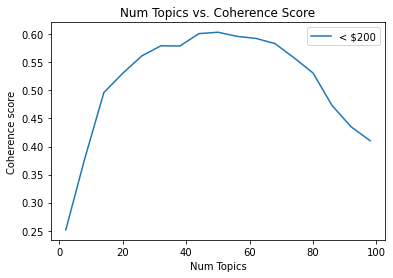

In [42]:
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_g0, label='< $200')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Num Topics vs. Coherence Score')
plt.legend()
plt.show()

In [44]:
lda = ldamodel.LdaModel(corpus=corpus_g0, id2word=id2word_g0, num_topics=40)

In [45]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 15);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

get_lda_topics(lda, 40)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 31,Topic # 32,Topic # 33,Topic # 34,Topic # 35,Topic # 36,Topic # 37,Topic # 38,Topic # 39,Topic # 40
0,put,record,country,war,play,find,product,would,city,word,...,be,can,life,part,state,name,accord,may,know,race
1,run,break,term,eat,tv,magazine,area,name,see,end,...,one,day,leave,body,people,song,build,hit,line,career
2,water,top,island,write,film,cover,join,latin,name,way,...,mountain,host,serve,plant,capital,team,family,novel,name,metal
3,sea,sound,company,fight,man,fish,believe,cry,found,begin,...,lie,eye,president,dance,live,mile,role,help,keep,talk
4,organ,invent,color,day,grow,tree,sit,mark,land,order,...,stand,refer,event,lose,road,place,address,hear,follow,item
5,insect,night,head,think,movie,king,river,bond,share,title,...,begin,see,spot,create,vote,wife,drive,try,send,brother
6,turn,win,name,shoot,drink,specie,change,peak,capital,creature,...,treat,card,honor,drop,kid,car,machine,baby,contain,receive
7,confederate,flower,town,festival,look,band,cheese,jail,street,mammal,...,bring,belong,mother,save,become,singer,plane,flow,apple,hospital
8,process,music,mean,depict,century,hell,author,say,shoe,year,...,find,name,buy,church,founder,rock,tape,catch,beverage,note
9,continent,law,food,reporter,field,window,lot,year,state,minute,...,learn,case,football,museum,governor,add,count,ocean,center,news


In [46]:
# ^ do this for every one of the 64 groups

### Analysis of lda by value

## Split each group further by year

In [48]:
dfs_val0_year = [x for _, x in dfs[0].groupby('year')]

In [49]:
len(dfs_val0_year)

29

In [50]:
# 29 x 64 = 1856 lda models lol